Importando librerías

In [2]:
import pyodbc 
import pandas as pd
import numpy as np

Conectamos Python con SQL mediante ODBC para extraer la base de datos desde el servidor local.

In [3]:
cnxn2 = pyodbc.connect("Driver={SQL Server};"
                      "Server=LAPTOP-SRBMTPNS;"
                      "Database=Varios;"
                      "Trusted_Connection=yes;")

Importando la tabla desde SQL

In [175]:
SobrevidaPY = pd.read_sql_query('select * from SobrevidaUchilePyth', cnxn2)

Descripción de la data.

In [357]:
SobrevidaPY.shape

(500, 6)

In [129]:
SobrevidaPY.head(100)

,tiempo,censura,estadio,tabaco,alcohol,antec
0,40.442436,0.0,0.0,0.0,1.0,1.0
1,39.938385,1.0,0.0,0.0,1.0,1.0
2,38.135082,1.0,0.0,0.0,1.0,1.0
3,35.773502,0.0,0.0,0.0,1.0,1.0
4,45.438084,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...
95,38.486019,1.0,1.0,1.0,0.0,1.0
96,28.950283,0.0,1.0,1.0,0.0,1.0
97,45.458092,1.0,1.0,1.0,0.0,1.0
98,37.794460,1.0,1.0,1.0,0.0,1.0


In [130]:
SobrevidaPY.dtypes

tiempo     float64
censura    float64
estadio    float64
tabaco     float64
alcohol    float64
antec      float64
dtype: object

Transformando cada variable en formato int64

In [176]:
SobrevidaPY["tiempo"]=SobrevidaPY["tiempo"].astype('int64')
SobrevidaPY["censura"]=SobrevidaPY["censura"].astype('int64')
SobrevidaPY["estadio"]=SobrevidaPY["estadio"].astype('int64')
SobrevidaPY["tabaco"]=SobrevidaPY["tabaco"].astype('int64')
SobrevidaPY["alcohol"]=SobrevidaPY["alcohol"].astype('int64')
SobrevidaPY["antec"]=SobrevidaPY["antec"].astype('int64')

In [177]:
SobrevidaPY.dtypes

tiempo     int64
censura    int64
estadio    int64
tabaco     int64
alcohol    int64
antec      int64
dtype: object

Se observan 79 casos censurados.

In [135]:
SobrevidaPY.groupby("censura").agg(frequency=("censura", "count"))

,frequency
censura,
0,79
1,421


Se observar 3 estadíos de la enfermedad siendo el más frecuente el tercer estadío y el menos frecuente el primero, lo que hace suponer que en su mayoría son enfermos terminales.

In [136]:
SobrevidaPY.groupby("estadio").agg(frequency=("estadio", "count"))

,frequency
estadio,
0,27
1,200
2,273


Con respecto al hábito del tabaco se observa mucho desbalance, siendo en su gran mayoría fumadores.

In [137]:
SobrevidaPY.groupby("tabaco").agg(frequency=("tabaco", "count"))

,frequency
tabaco,
0,64
1,436


Con respecto al consumo de alcohol también se observa mucho desbalance observándose mayoritariamente una muestra de la población que no es bebedora.


In [138]:
SobrevidaPY.groupby("alcohol").agg(frequency=("alcohol", "count"))

,frequency
alcohol,
0,473
1,27


El 70% de los pacientes poseen antecedentes familiares de la enfermedad.


In [139]:
SobrevidaPY.groupby("antec").agg(frequency=("antec", "count"))

,frequency
antec,
0,151
1,349


Importando Kaplan Meier desde Lifelines

In [17]:
from lifelines import KaplanMeierFitter

Al ensayar la sobrevida de Kaplan-Meier observamos que el resultado es el mismo observado en Stata y R, es decir, el 50% de los pacientes aún estaba vivo a los 37 meses (percentil 50)

In [140]:
kmf=KaplanMeierFitter() 

Creando los objetos Tiempo y Censura

In [141]:
T=SobrevidaPY['tiempo']
C=SobrevidaPY['censura']

Entrenando el modelo

In [142]:
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 500 total observations, 79 right-censored observations>

Obtenemos y graficamos la función de sobrevida

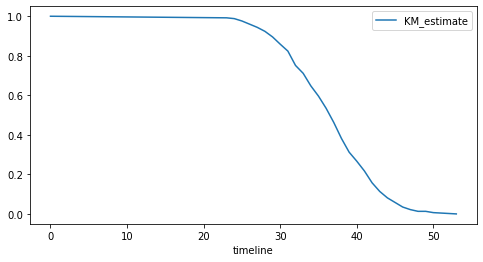

In [143]:
S=kmf.survival_function_
S.plot()

Obtenemos y graficamos la función de sobrevida acumulada (Nelson-Aalen)


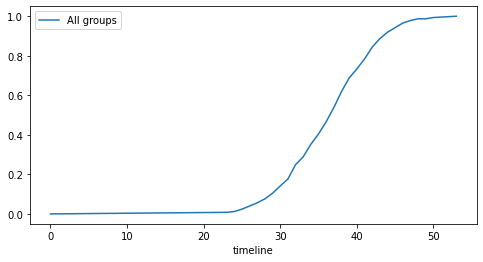

In [58]:
Cum=kmf.cumulative_density_
Cum.plot()

Al observar los percentiles notaremos que a los 33 meses estaba vivo el 75% de los pacientes. La lógica acumulativa de los percentiles es inversa a la de R.

In [23]:
kmf.percentile(0.25)

41.0

In [24]:
kmf.percentile(0.5)

37.0

In [25]:
kmf.percentile(0.75)

33.0

Gráfico de la sobrevida con intervalos de confianza

Populating the interactive namespace from numpy and matplotlib


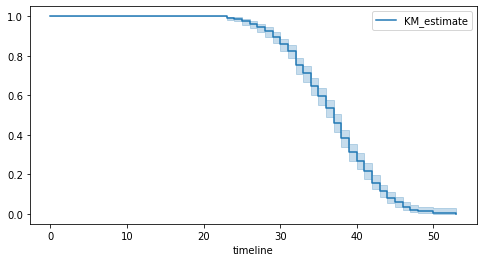

In [26]:
%pylab inline
figsize(8,4)
kmf.plot()

Gráfico de la sobrevida acumulada con intervalos de confianza

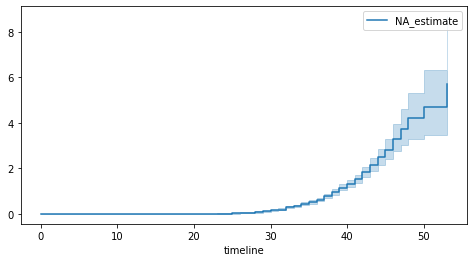

In [27]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(T, event_observed=C)
naf.plot()

Analizaremos las curvas de sobrevida en cada grupo de cada covariable y aplicaremos la dócima de Log Rank para evaluar la existencia de diferencias significativas entre grupos. A diferencia de lo realizado en R, en python realizaremos el modelo de Cox en términos multivariados para evaluar el supuesto de los riesgos proporcionales.


Antes de esto, y dado que la covariable estadío de la enfermedad es una variable categórica de tres niveles, es necesario crear variables dummy.

In [178]:
dummies = pd.get_dummies(SobrevidaPY['estadio']).rename(columns=lambda x: 'estadio_' + str(x))
dummies

,estadio_0,estadio_1,estadio_2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
495,0,0,1
496,0,0,1
497,0,0,1
498,0,0,1


In [436]:
SobrevidaPYdum= pd.concat([SobrevidaPY, dummies], axis=1)
SobrevidaPYdum

,tiempo,censura,estadio,tabaco,alcohol,antec,estadio_0,estadio_1,estadio_2
0,40,0,0,0,1,1,1,0,0
1,39,1,0,0,1,1,1,0,0
2,38,1,0,0,1,1,1,0,0
3,35,0,0,0,1,1,1,0,0
4,45,1,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...
495,39,1,2,1,0,0,0,0,1
496,34,1,2,1,0,1,0,0,1
497,39,1,2,1,0,0,0,0,1
498,31,0,2,1,0,0,0,0,1


Estadío:

creamos los grupos para esta covariable y el gráfico correspondiente.

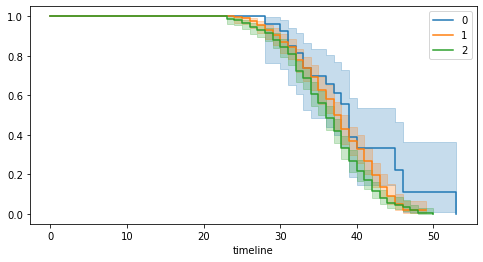

In [28]:
groups = SobrevidaPY['estadio']

ix0 = (groups == 0)
ix1 = (groups == 1)
ix2 = (groups == 2)

kmf.fit(T[ix0], C[ix0], label=0)
ax0 = kmf.plot()

kmf.fit(T[ix1], C[ix1], label=1)
ax1 = kmf.plot()


kmf.fit(T[ix2], C[ix2], label=2)
kmf.plot(ax=ax0)

Importamos la librería correspondiente y creamos los grupos para la comparación mediante la dócima

In [29]:
from lifelines.statistics import logrank_test

In [30]:
group0=SobrevidaPY[SobrevidaPY['estadio']==0]
group1=SobrevidaPY[SobrevidaPY['estadio']==1]
group2=SobrevidaPY[SobrevidaPY['estadio']==2]
T0=group0['tiempo']
C0=group0['censura']
T1=group1['tiempo']
C1=group1['censura']
T2=group2['tiempo']
C2=group2['censura']

kmf = KaplanMeierFitter()

La dócima de Log Rank confirma la existencia diferencias significativas entre los 3 grupos.

Comparando el estadio cero con el estadio uno

In [397]:
results = logrank_test(T0, T1, event_observed_A=C0, event_observed_B=C1) 
results.summary

,test_statistic,p
0,1.360147,0.243512



Comparando el estadio uno con el estadio dos


In [398]:
results = logrank_test(T1, T2, event_observed_A=C1, event_observed_B=C2) 
results.summary


,test_statistic,p
0,3.3485,0.067266



Comparando el estadio cero con el estadio dos


In [399]:
results = logrank_test(T0, T2, event_observed_A=C0, event_observed_B=C2) 
results.summary

,test_statistic,p
0,0.183951,0.668


Tabaco:

Los pacientes con hábito de tabaquismo parecen ser más riesgosos.


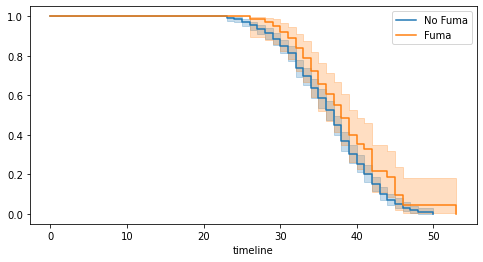

In [34]:
groups = SobrevidaPY['tabaco']
ix = (groups == 0)

kmf.fit(T[~ix], C[~ix], label="No Fuma")
ax = kmf.plot()

kmf.fit(T[ix], C[ix], label="Fuma")
kmf.plot(ax=ax)

La dócima de Log Rank confirma un efecto significativo de la covariable sobre la variable de interés. Aunque el valor del test estadístico es levemente diferente al entregado por Stata y R.


In [35]:
group0=SobrevidaPY[SobrevidaPY['tabaco']==0]
group1=SobrevidaPY[SobrevidaPY['tabaco']==1]

T0=group0['tiempo']
C0=group0['censura']
T1=group1['tiempo']
C1=group1['censura']

kmf = KaplanMeierFitter()

In [400]:
results = logrank_test(T0, T1, event_observed_A=C0, event_observed_B=C1) 
results.summary

,test_statistic,p
0,1.360147,0.243512


Alcohol:

Los pacientes con hábito de consumo de alcohol presentan una sobrevida superior.


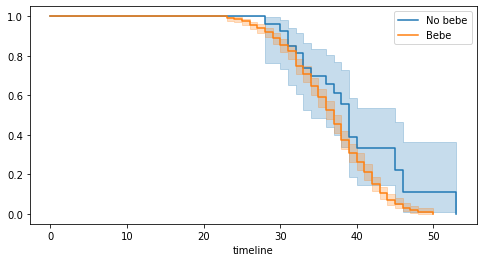

In [37]:
groups = SobrevidaPY['alcohol']
ix = (groups == 0)
kmf.fit(T[~ix], C[~ix], label="No bebe")
ax = kmf.plot()
kmf.fit(T[ix], C[ix], label="Bebe")
kmf.plot(ax=ax)

La dócima de Log Rank muestra un efecto significativo de la covariable sobre la variable de interés. Aunque el valor del test estadístico es levemente diferente al entregado por Stata y R.

In [38]:
group0=SobrevidaPY[SobrevidaPY['alcohol']==0]
group1=SobrevidaPY[SobrevidaPY['alcohol']==1]

T0=group0['tiempo']
C0=group0['censura']
T1=group1['tiempo']
C1=group1['censura']

kmf = KaplanMeierFitter()

In [401]:
results = logrank_test(T0, T1, event_observed_A=C0, event_observed_B=C1) 
results.summary

,test_statistic,p
0,1.360147,0.243512


Antecedentes Familiares:
Parece no existir un efecto significativo de esta covariable sobre el evento de interés.

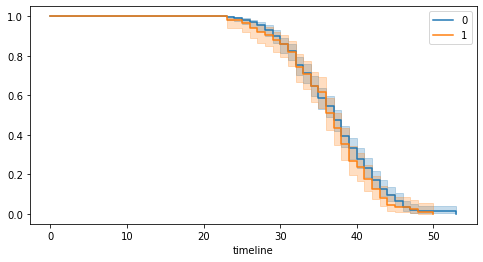

In [40]:
groups = SobrevidaPY['antec']
ix = (groups == 0)
kmf.fit(T[~ix], C[~ix], label=0)
ax = kmf.plot()
kmf.fit(T[ix], C[ix], label=1)
kmf.plot(ax=ax)

La dócima de Log Rank no muestra un efecto significativo de la covariable sobre la variable de interés.

In [41]:
group0=SobrevidaPY[SobrevidaPY['antec']==0]
group1=SobrevidaPY[SobrevidaPY['antec']==1]

T0=group0['tiempo']
C0=group0['censura']
T1=group1['tiempo']
C1=group1['censura']

kmf = KaplanMeierFitter()

In [402]:
results = logrank_test(T0, T1, event_observed_A=C0, event_observed_B=C1) 
results.summary

,test_statistic,p
0,1.360147,0.243512


Para evaluar la proporcionalidad de los riesgos realizaremos el modelo completo de riesgos proporcionales de Cox. 
Utilizaremos check_assumptions y proportional hazar test para este efecto. 
Por otro lado, debido al notorio desbalance de la variable estadío, ocurre multicolinealidad, por lo que sólo se debe considerar la variable dummy estadio_2. 
A diferencia de R y Python, Stata detecta la multicolinelidad y hace la exclusión automáticamente.

Eliminamos entonces la covariable y las variables dummy que producen multicolinealidad.

In [180]:
SobrevidaPYdum=SobrevidaPYdum.drop(['estadio'], axis=1)
SobrevidaPYdum=SobrevidaPYdum.drop(['estadio_0'], axis=1)
SobrevidaPYdum=SobrevidaPYdum.drop(['estadio_1'], axis=1)

In [145]:
SobrevidaPYdum

,tiempo,censura,tabaco,alcohol,antec,estadio_2
0,40,0,0,1,1,0
1,39,1,0,1,1,0
2,38,1,0,1,1,0
3,35,0,0,1,1,0
4,45,1,0,1,1,0
...,...,...,...,...,...,...
495,39,1,1,0,0,1
496,34,1,1,0,1,1
497,39,1,1,0,0,1
498,31,0,1,0,0,1


Importamos las librerías necesaria para el modelo semiparamétrico de Cox y entrenamos el modelo.

In [146]:
from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
cph = CoxPHFitter()

cph.fit(SobrevidaPYdum, "tiempo", "censura")

<lifelines.CoxPHFitter: fitted with 500 total observations, 79 right-censored observations>

Resultados del modelo de Cox

In [434]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
tabaco,0.024019,1.024310,0.208357,-0.384354,0.432393,0.680891,1.540940,0.115280,0.908223,0.138881
alcohol,-0.414207,0.660864,0.309502,-1.020819,0.192406,0.360300,1.212162,-1.338301,0.180798,2.467547
antec,0.084418,1.088084,0.128977,-0.168373,0.337209,0.845039,1.401031,0.654518,0.512778,0.963594
estadio_2,0.266541,1.305441,0.128734,0.014226,0.518856,1.014328,1.680104,2.070470,0.038408,4.702437


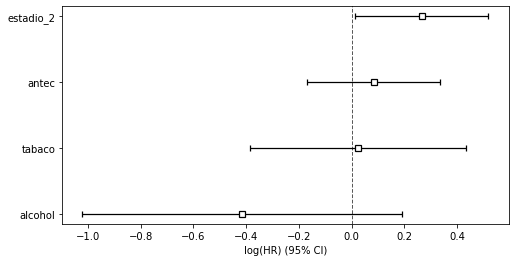

In [148]:
cph.plot()

Lifelines entrega un reporte muy completo en el que, entre otras situaciones, se revisan los residuos de schoenfeld. Sin embargo al no encontrar inconsistencia en la proporcionalidad de los riersgos el informe sólo se reduce al siguiente mensaje.

In [149]:
cph.check_assumptions(SobrevidaPYdum, p_value_threshold=0.05, show_plots=True)  

Proportional hazard assumption looks okay.


El informe mencionado anteriormente también contiene el siguiente test el cual es posible consultar individualmente invocando los comandos para observar, para cada variable, el valor del test estadístico aplicado y el p-value. 

In [150]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, SobrevidaPYdum, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

Buscaremos un ajuste paramétrico dentro de la familia de las exponenciales.

Importamos la librería correspondiente

In [49]:
import statsmodels.api as st

Los datos distribuyen exponencial?

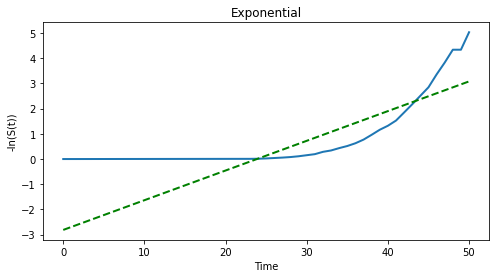

In [151]:
kmf.fit(T,event_observed = C, label = "All groups")
plt.figure()
plt.plot(kmf.survival_function_.index.values,-np.log(kmf.survival_function_['All groups']),linewidth = 2.0)
plt.ylabel('-ln(S(t))')
plt.xlabel('Time')
plt.title('Exponential')
S=kmf.survival_function_[:50] # eliminamos el último registro por ser =0; -log(0)= infinito, lo que afecta a la correlación
y = -np.log(S['All groups'])
X = np.asarray(S.index.values)
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

No se observa un buen ajuste con la regresión exponencial

Los datos distribuyen Weibull?

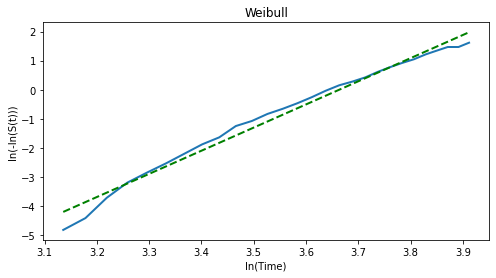

In [152]:
S=kmf.survival_function_[:50]
plt.figure()
plt.plot(np.log(S.index.values),np.log(-np.log(S['All groups'])),linewidth = 2.0)
plt.ylabel('ln(-ln(S(t)))')
plt.xlabel('ln(Time)')
plt.title('Weibull')

y = np.log(-np.log(S['All groups'].iloc[1:len(S)]))
X = np.log(S.index.values[1:len(S.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

Al igual que Stata y R, el ajuste weibull se presenta como una buena alternativa.

Los datos distribuyen gompertz?

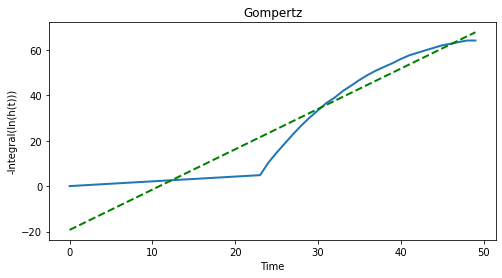

In [153]:
S=kmf.survival_function_[:50]
plt.figure()
t_1 = S.iloc[0:len(S) - 1]
t_2 = S.iloc[1:len(S)]
gompertz_hazard = []
gompertz_hazard.append(0)
for index in range(len(t_1)):
    #Because we are summing the log of the hazard, check if the 
    #hazard is zero between t_2 and t_1. 
    if (-np.log(t_2.iloc[index,0])+np.log(t_1.iloc[index,0])) > 0:
        gompertz_hazard.append(gompertz_hazard[index] - np.log(-np.log(t_2.iloc[index,0])+np.log(t_1.iloc[index,0])))
    else:
    #If it is, append the latest value of the cumulative hazard at time t_2
        gompertz_hazard.append(gompertz_hazard[index])
plt.plot(t_1.index.values,gompertz_hazard[:-1],linewidth = 2.0)
plt.title('Gompertz')
plt.ylabel('-Integral(ln(h(t)))')
plt.xlabel('Time')
y = gompertz_hazard[:-1]
X = t_1.index.values
X = st.add_constant(X,prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,0],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

Los datos distribuyen  Log-Logistic

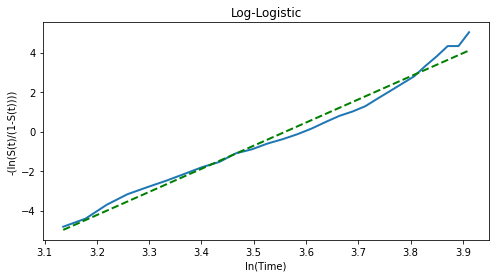

In [154]:
S=kmf.survival_function_[:50]
plt.figure()
plt.plot(np.log(S.index.values),-np.log(S['All groups']/(1-S['All groups'])),linewidth = 2.0)
plt.ylabel('Probability of ending')
plt.xlabel('Years')
plt.title('Log-Logistic')
plt.ylabel('-(ln(S(t)/(1-S(t))))')
plt.xlabel('ln(Time)')
y = -np.log(S['All groups'].iloc[1:len(S)]/(1-S['All groups'].iloc[1:len(S)]))
X = np.log(S.index.values[1:len(S.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

In [155]:
from scipy.stats import norm

Los datos distribuyen Log-Normal?

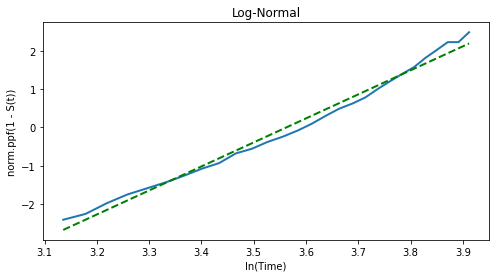

In [156]:
S=kmf.survival_function_[:50]
plt.figure()
plt.plot(np.log(S.index.values),norm.ppf(1 - S['All groups']),linewidth = 2.0)
plt.xlabel('Years')
plt.title('Log-Normal')
plt.ylabel('norm.ppf(1 - S(t))')
plt.xlabel('ln(Time)')
y = norm.ppf(1 - S['All groups'].iloc[1:len(S)])
X = np.log(S.index.values[1:len(S.index.values)])
X = st.add_constant(X, prepend=False)
linearmodel = st.OLS(y,X)
linearmodelresults = linearmodel.fit()
plt.plot(X[:,[0]],linearmodelresults.fittedvalues,'g--',linewidth = 2.0)

Ajustaremos los datos a un modelo paramétrico

Creamos un objeto auxiliar que nos permita ingresar sólo las covariables necesarias para ensayar los modelos multivariados. 

In [227]:
SobrevidaPYdum1=SobrevidaPYdum

In [228]:
SobrevidaPYdum1=SobrevidaPYdum1.drop(['tiempo'], axis=1)
SobrevidaPYdum1=SobrevidaPYdum1.drop(['censura'], axis=1)

In [232]:
censura=SobrevidaPYdum['censura']
tiempo=SobrevidaPYdum['tiempo']

In [272]:
SobrevidaPYdum1 = st.add_constant(SobrevidaPYdum1, prepend=False)

In [273]:
SobrevidaPYdum1

,tabaco,alcohol,antec,estadio_2,const
0,0,1,1,0,1.0
1,0,1,1,0,1.0
2,0,1,1,0,1.0
3,0,1,1,0,1.0
4,0,1,1,0,1.0
...,...,...,...,...,...
495,1,0,0,1,1.0
496,1,0,1,1,1.0
497,1,0,0,1,1.0
498,1,0,0,1,1.0


Ajuste Exponencial Exponencial PH

Python es un lenguaje de programación, por ende en muchos casos es necesario definir clases, generadores y funciones como ocurrirá en los ajustes de los modelos paramétricos.

In [313]:
class ExponentialPH(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(ExponentialPH, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        ll = _ll_exponentialph(self.endog,self.exog,params)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if start_params == None:
            start_params = start_params_var 
        return super(ExponentialPH, self).fit(start_params = start_params, method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

In [314]:
kmf.fit(tiempo,event_observed = censura,label = "All groups")
#ExponentialPH
start_params_var = np.repeat(0,len(SobrevidaPYdum1.columns))
mod_exponentialph = ExponentialPH(tiempo,SobrevidaPYdum1)
res_expPH = mod_exponentialph.fit()
print(res_expPH.summary())

Optimization terminated successfully.
         Current function value: 3.997858
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 26
         Hessian evaluations: 13
                            ExponentialPH Results                             
Dep. Variable:                 tiempo   Log-Likelihood:                -1998.9
Model:                  ExponentialPH   AIC:                             4008.
Method:            Maximum Likelihood   BIC:                             4029.
Date:                Mon, 01 Jun 2020                                         
Time:                        12:50:07                                         
No. Observations:                 500                                         
Df Residuals:                     495                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----

Los HR para cada variable son los siguientes:
tabaco= 1.079; alcohol= 0.8642; antec= 1.067; estadío_2= 1.1613

Los pacientes en estadío 2 tienen un riesgo relativo de un 16% superior de realizar el evento de interés, por otro lado los pacientes que consumen alcohol tienen un 14% menos. Estos resultados son muy similares a los obtenidos en Stata y R.

Ajuste Weibull PH

In [315]:
class WeibullPH(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(WeibullPH, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_weibullph(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(WeibullPH, self).fit(start_params = start_params,method = 'basinhopping',maxiter = maxiter, maxfun = maxfun,**kwds)

In [316]:
start_params_var = np.repeat(1,len(SobrevidaPYdum1.columns) + 1)
mod_weibullph = WeibullPH(tiempo,SobrevidaPYdum1)
res_weiPH = mod_weibullph.fit()
print(res_weiPH.summary())

basinhopping step 0: f 2.75489
basinhopping step 1: f 2.75489 trial_f 2.75489 accepted 1  lowest_f 2.75489
basinhopping step 2: f 2.75489 trial_f 2.75489 accepted 1  lowest_f 2.75489
basinhopping step 3: f 2.75489 trial_f 2.75489 accepted 1  lowest_f 2.75489
found new global minimum on step 3 with function value 2.75489
basinhopping step 4: f 2.75489 trial_f 2.75489 accepted 1  lowest_f 2.75489
basinhopping step 5: f 2.75489 trial_f 2.75489 accepted 1  lowest_f 2.75489
basinhopping step 6: f 2.75489 trial_f 2.75489 accepted 1  lowest_f 2.75489
found new global minimum on step 6 with function value 2.75489
basinhopping step 7: f 2.75489 trial_f 2.75489 accepted 1  lowest_f 2.75489
found new global minimum on step 7 with function value 2.75489
basinhopping step 8: f 2.75489 trial_f 2.75489 accepted 1  lowest_f 2.75489
found new global minimum on step 8 with function value 2.75489
basinhopping step 9: f 2.75489 trial_f 2.75489 accepted 1  lowest_f 2.75489
basinhopping step 10: f 2.75489 t

Los HR para cada variable son los siguientes:
tabaco= 1.003; alcohol= 0.5934; antec= 1.087; estadío_2= 1.299

Los pacientes en estadío 2 tienen un riesgo relativo de un 30% superior de realizar el evento de interés, por otro lado los pacientes que consumen alcohol tienen un 41% menos. Estos resultados son muy similares a los obtenidos en Stata y R.

Ajuste Gompertz PH

In [317]:
class GompertzPH(GenericLikelihoodModel):
    def _init_(self,endog,exog,**kwds):
        super(GompertzPH, self).__init__(endog,exog,**kwds)
    def nloglikeobs(self,params):
        gamma = params[-1]
        beta = params[:-1]
        ll = _ll_gompertzph(self.endog,self.exog,beta,gamma)
        return -ll
    def fit(self, start_params = None, maxiter = 10000,maxfun = 5000,**kwds):
        if len(self.exog_names) == len(self.exog[1]):
            self.exog_names.append('gamma')        
        if start_params == None:
            start_params = start_params_var 
        return super(GompertzPH, self).fit(start_params = start_params,method = 'ncg',maxiter = maxiter, maxfun = maxfun,**kwds)

In [318]:
start_params_var = np.repeat(0,len(SobrevidaPYdum1.columns))
start_params_var = np.append(start_params_var,1)
mod_gompertzph = GompertzPH(tiempo,SobrevidaPYdum1)
res_gompPH = mod_gompertzph.fit()
print(res_gompPH.summary())

Optimization terminated successfully.
         Current function value: 2.791886
         Iterations: 82
         Function evaluations: 104
         Gradient evaluations: 185
         Hessian evaluations: 82
                              GompertzPH Results                              
Dep. Variable:                 tiempo   Log-Likelihood:                -1395.9
Model:                     GompertzPH   AIC:                             2802.
Method:            Maximum Likelihood   BIC:                             2823.
Date:                Mon, 01 Jun 2020                                         
Time:                        12:51:40                                         
No. Observations:                 500                                         
Df Residuals:                     495                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Los HR para cada variable son los siguientes:
tabaco= 0.983; alcohol= 0.51; antec= 1.085; estadío_2= 1.291

Los pacientes en estadío 2 tienen un riesgo relativo de un 29% superior de realizar el evento de interés, por otro lado los pacientes que consumen alcohol tienen un 49% menos. Estos resultados son muy similares a los obtenidos en Stata y R.